# Trend algorithm and test

The algorithm needs to proceed in two steps:
(1) Use the Mann-Kendall test to detect presence of a trend
(2) IF the test retruns true, filter the series and identify whether linear or other

The second part of the notebook will work through various examples

## Algorithm

In [27]:
import pyleoclim as pyleo
import numpy as np
import pymannkendall as mk
import pandas as pd
from scipy.optimize import curve_fit
from kneed import KneeLocator

The following functions are used to calculate goodness of fit between data and various polynomials using the RMSE

In [12]:
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def poly1(x,a,b):
    return a*x+b

def poly2(x,a,b,c):
    return a*x**2+b*x+c

def poly3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def poly4(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e

def poly5(x,a,b,c,d,e,f):
    return a*x**5+b*x**4+c*x**3+d*x**2+e*x+f

def poly6(x,a,b,c,d,e,f,g):
    return a*x**6+b*x**5+c*x**4+d*x**3+e*x**2+f*x+g

def poly7(x,a,b,c,d,e,f,g,h):
    return a*x**7+b*x**6+c*x**5+d*x**4+e*x**3+f*x**2+g*x+h

def fit_good(time,value):

    rmse = []
    funcs = ['poly0','poly1','poly2','poly3','poly4','poly5','poly6','poly7']

    for func in funcs:
        if func == 'poly0':
            preds = np.full(np.shape(time),np.mean(value))
        elif func == 'poly1':
            params,covs = curve_fit(poly1,time,value)
            preds = poly1(time,*params)
        elif func == 'poly2':
            params,covs = curve_fit(poly2,time,value)
            preds = poly2(time,*params)
        elif func == 'poly3':
            params,covs = curve_fit(poly3,time,value)
            preds = poly3(time,*params)
        elif func == 'poly4':
            params,covs = curve_fit(poly4,time,value)
            preds = poly4(time,*params)
        elif func == 'poly5':
            params,covs = curve_fit(poly5,time,value)
            preds = poly5(time,*params)
        elif func == 'poly6':
            params,covs = curve_fit(poly6,time,value)
            preds = poly6(time,*params)
        elif func == 'poly7':
            params,covs = curve_fit(poly7,time,value)
            preds = poly7(time,*params)
        rmse.append(calculate_rmse(preds,value))
    res = pd.DataFrame({'Fit':funcs,'RMSE':rmse})
    return res

New function:

In [14]:
def IDTrend(time,value):
    mk_res = mk.hamed_rao_modification_test(value, lag=1)
    if mk_res.h ==False:
        trend = 'no_trend'
    elif mk_res.h==True:
        ts=pyleo.Series(time,value)
        ts_filt=ts.interp().filter(cutoff_scale = np.ptp(time), method = 'lanczos')
        rmse = fit_good(ts_filt.time,ts_filt.value)
        kneedle = KneeLocator(np.arange(0,len(rmse['RMSE']),1), rmse['RMSE'], S=1.0, curve="convex", direction="decreasing")
        n=round(kneedle.knee, 1)
        if n==0:
            trend='no_trend'
        elif n==1:
            trend='linear'
        else:
            trend ='other'
    return trend

## Test on pseudo data

In [6]:
def add_trend(time, value, trend_type='linear'):
    
    if trend_type=='linear':
        
        slope = 0.01
        intercept = -1
        ys = time*slope+intercept
    
    elif trend_type=='polynomial':
        slope = 1e-5
        intercept = -1
        ys = slope*time**2+intercept
    
    elif trend_type=='sinusoidal':
        freqs=1/1500
        ys= 2*np.std(value)*np.cos(2*np.pi*freqs*time)
        
    elif trend_type =='s-shape':
        cut=[666,1332]
        value_offset_1 = np.mean(value[:cut[0]])+8
        value_offset_2 = np.mean(value[cut[1]:])
        slope = (value_offset_2-value_offset_1)/(time[cut[1]]-time[cut[0]])
        intercept = value_offset_2-(slope*time[cut[1]])
        
        ys=np.zeros(len(time))
        ys[0:cut[0]] = value_offset_1
        ys[cut[0]:cut[1]] = time[cut[0]:cut[1]]*slope+intercept
        ys[cut[1]:] = value_offset_2
        
    return ys

def create_signal(trend_type='linear'):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)

    # Add colored noise

    t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
    noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
    ### add trend
    if trend_type is None:
        signal_trend = noisy_sig
    else:
        signal_trend = noisy_sig+add_trend(time,noisy_sig,trend_type=trend_type)
    
    return time,signal_trend

In [18]:
trend_type = [None,'linear','polynomial','sinusoidal','s-shape']
id_trend = []
truth_trend = ['no_trend','linear','other','other','other']
for trend in trend_type:
    time,value = create_signal(trend_type=trend)
    id_trend.append(IDTrend(time,value))

summary = pd.DataFrame({'Added Trend':trend_type,'Ground Truth':truth_trend,'Identified Trend':id_trend})
summary

,Added Trend,Ground Truth,Identified Trend
0,None,no_trend,no_trend
1,linear,linear,linear
2,polynomial,other,other
3,sinusoidal,other,other
4,s-shape,other,other


## Test on Real Data

### MD98-2181

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: MD982181.Khider.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 1 record
extracting paleoData...
extracting: MD982181.Khider.2014
Created time series: 31 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

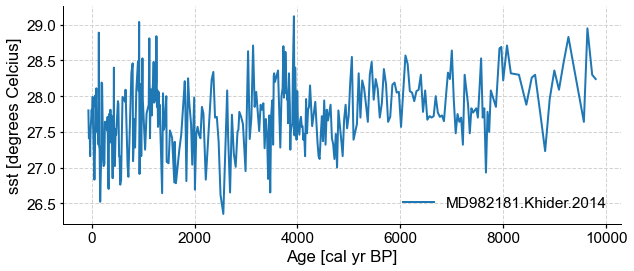

In [16]:
D=pyleo.Lipd('../Outlier/MD982181.Khider.2014.lpd')
ts_MD81=D.to_LipdSeries(number=14)
ts_MD81.plot()

In [19]:
IDTrend(ts_MD81.time,ts_MD81.value)

'linear'

### GISP2

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

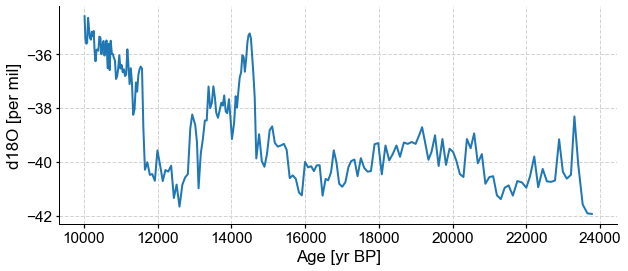

In [20]:
df = pd.read_csv('../Outlier/GISP2_Deglacial.csv')
ts_GISP=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')
ts_GISP.plot()

In [21]:
IDTrend(ts_GISP.time,ts_GISP.value)

'other'

### LR04

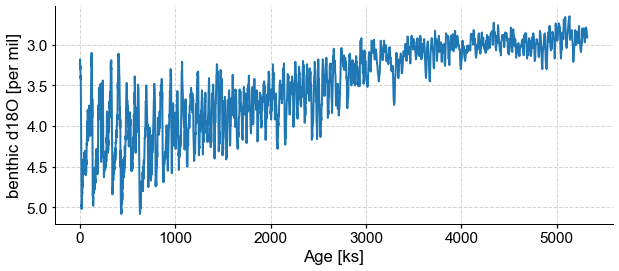

In [23]:
df = pd.read_csv('../Outlier/LR04.csv',skiprows=4)
ts_LR04=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')

fig,ax = ts_LR04.plot()
ax.invert_yaxis()

In [24]:
IDTrend(ts_LR04.time,ts_LR04.value)

'other'

### Nino 3

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Year [CE]', ylabel='Niño 3 [$^{\\circ}$C]'>)

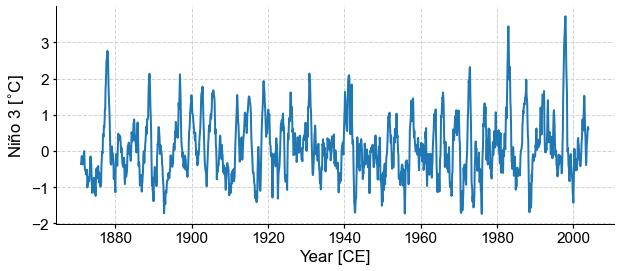

In [25]:
df = pd.read_csv('wtc_test_data_nino_even.csv')

ts_nino = pyleo.Series(time =  df['t'], value = df['nino'],
                  time_name = 'Year', value_name = 'Niño 3',
                  time_unit = 'CE', value_unit = '$^{\circ}$C')

ts_nino.plot()

In [26]:
IDTrend(ts_nino.time,ts_nino.value)

'no_trend'